Paper link - http://arxiv.org/abs/1805.02867

In [1]:
import numpy as np

In [2]:
ip = [2,4,1,300,400,500,600,700,800,900,100000]
ip_n = np.array(ip)

In [3]:
ip_n

array([     2,      4,      1,    300,    400,    500,    600,    700,
          800,    900, 100000])

# Normal Softmax: Naive softmax

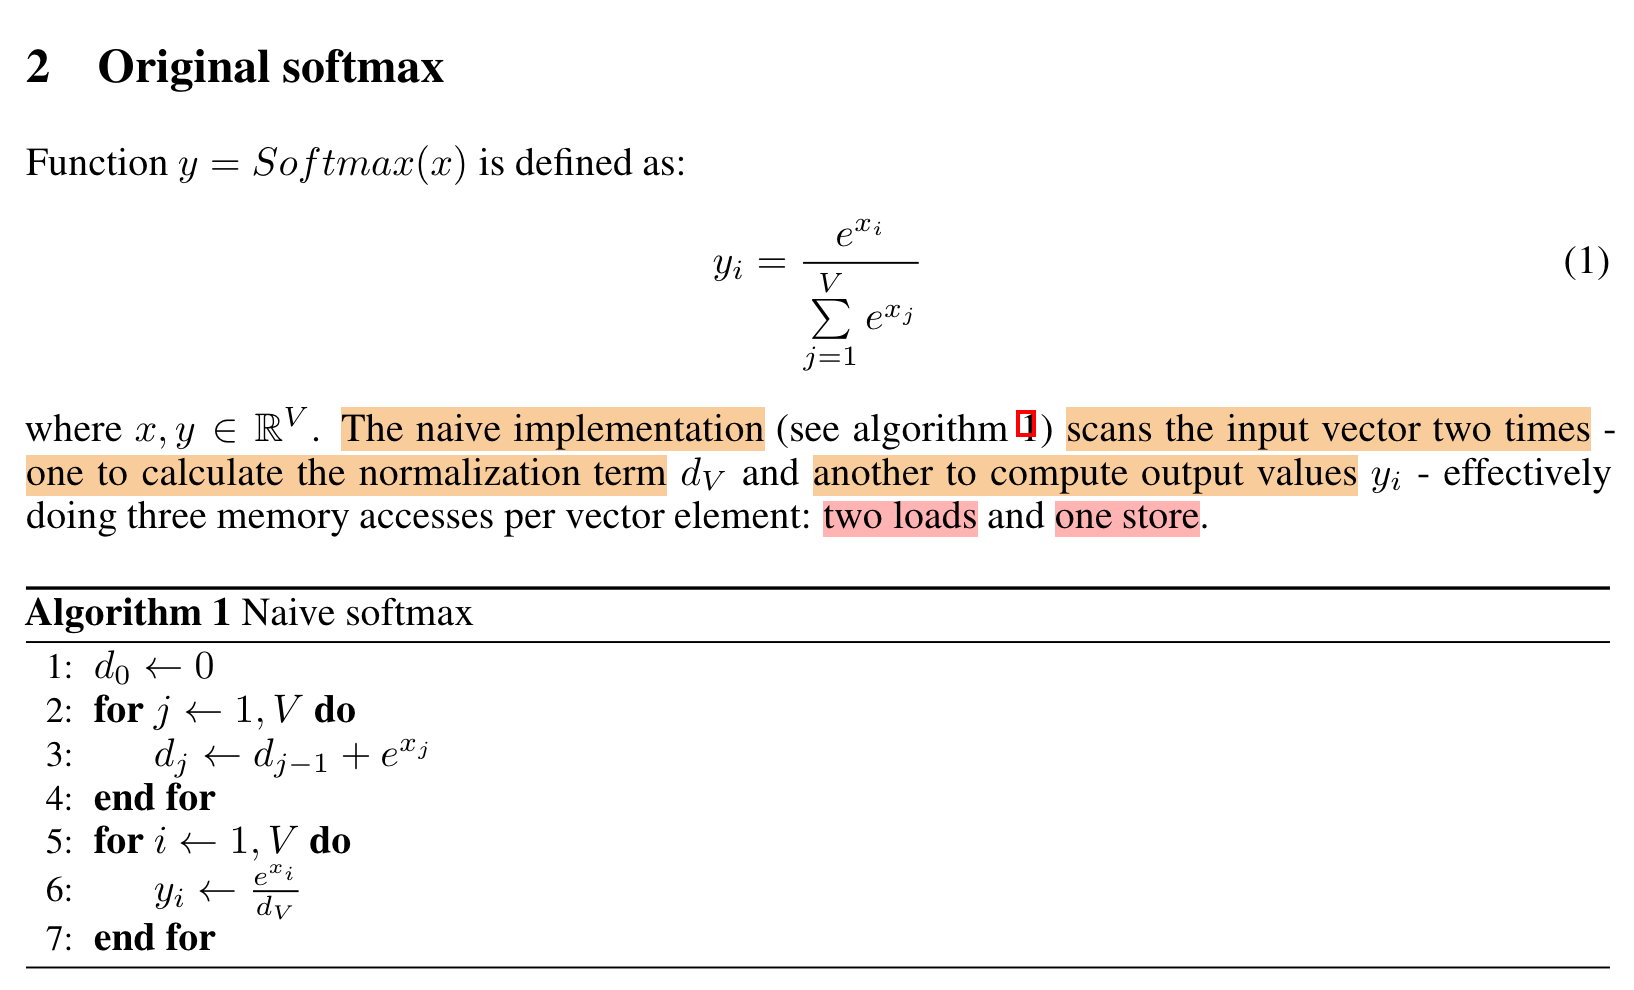

In [4]:
np.inf / np.inf

nan

In [5]:
%%time
ip_e = np.exp(ip_n) # inf will occur due to large values going into exp
print(ip_e)
_softmax = ip_e / ip_e.sum() # nan's due to inf/inf
print(_softmax)

[7.38905610e+000 5.45981500e+001 2.71828183e+000 1.94242640e+130
 5.22146969e+173 1.40359222e+217 3.77302030e+260 1.01423205e+304
             inf             inf             inf]
[ 0.  0.  0.  0.  0.  0.  0.  0. nan nan nan]
CPU times: user 5.86 ms, sys: 1.11 ms, total: 6.96 ms
Wall time: 1.73 ms


<timed exec>:1: RuntimeWarning: overflow encountered in exp
<timed exec>:3: RuntimeWarning: invalid value encountered in divide


# Safe softmax: "max" value removed

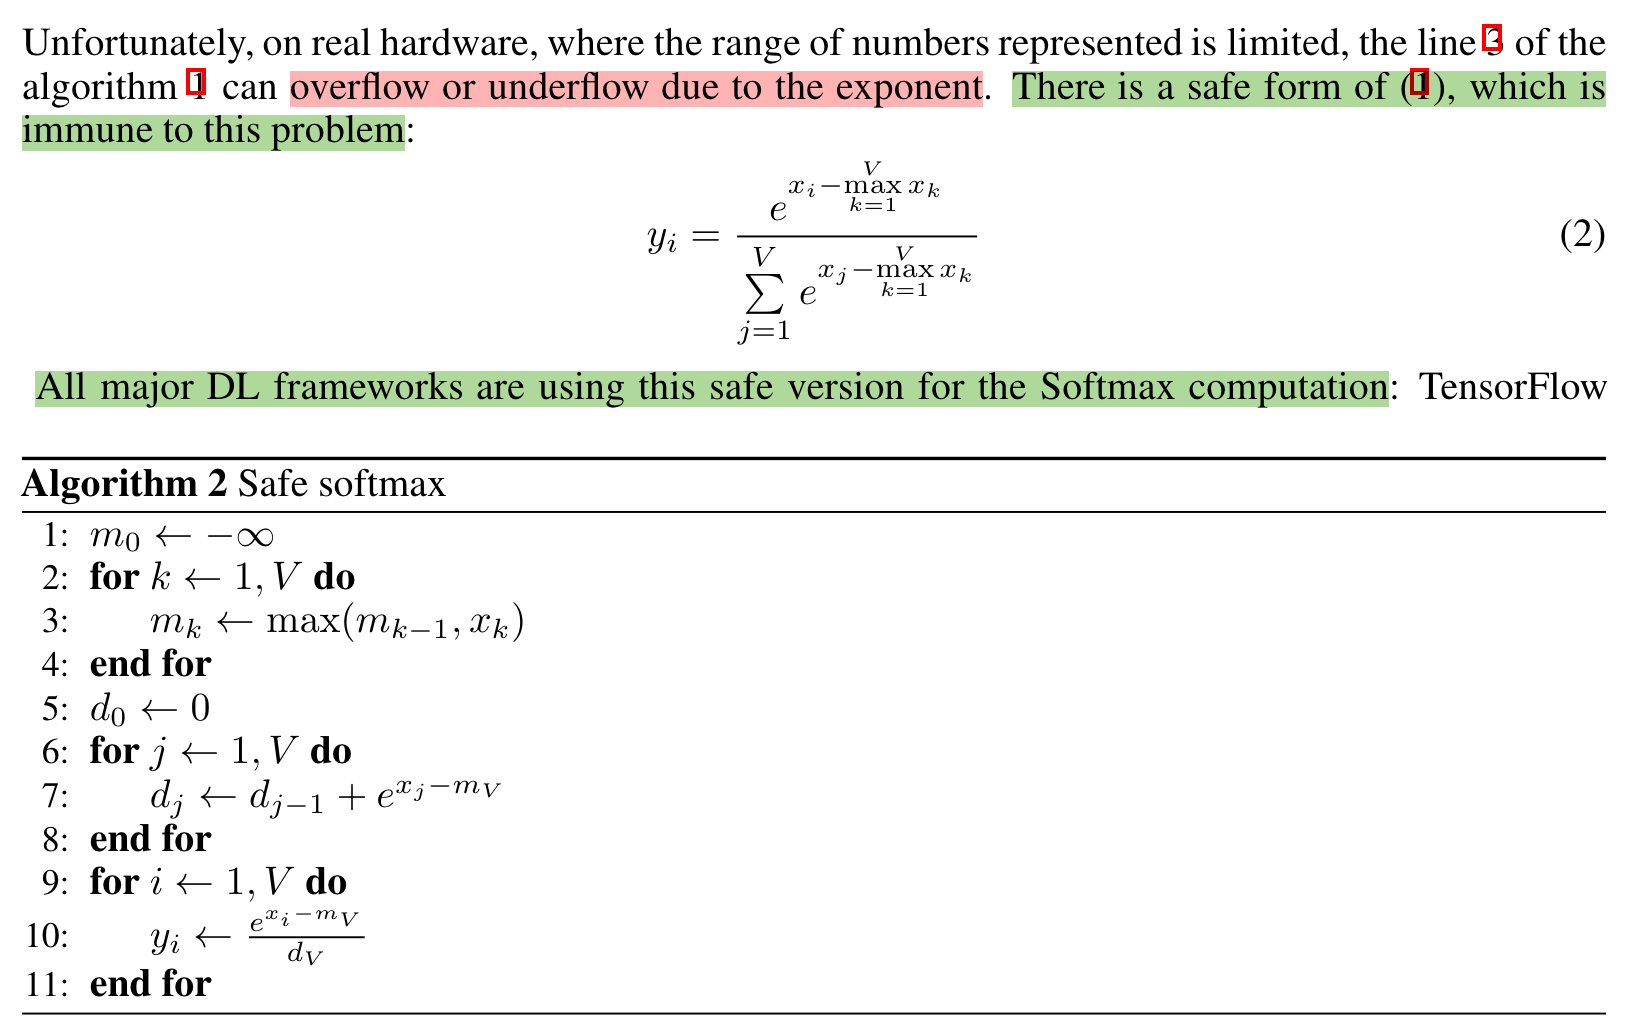

In [6]:
x = ip_n-max(ip_n)
x

array([-99998, -99996, -99999, -99700, -99600, -99500, -99400, -99300,
       -99200, -99100,      0])

In [7]:
%%time
x = ip_n-max(ip_n) # 1st memory access
ip_e = np.exp(x) # 2nd memory access
print(ip_e)
_softmax = ip_e / ip_e.sum() # sum: 3rd memory access; store in _softmax: 4th memory access
print(_softmax)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
CPU times: user 1.68 ms, sys: 79 µs, total: 1.76 ms
Wall time: 213 µs


# Safe softmax: online normalizer calculation

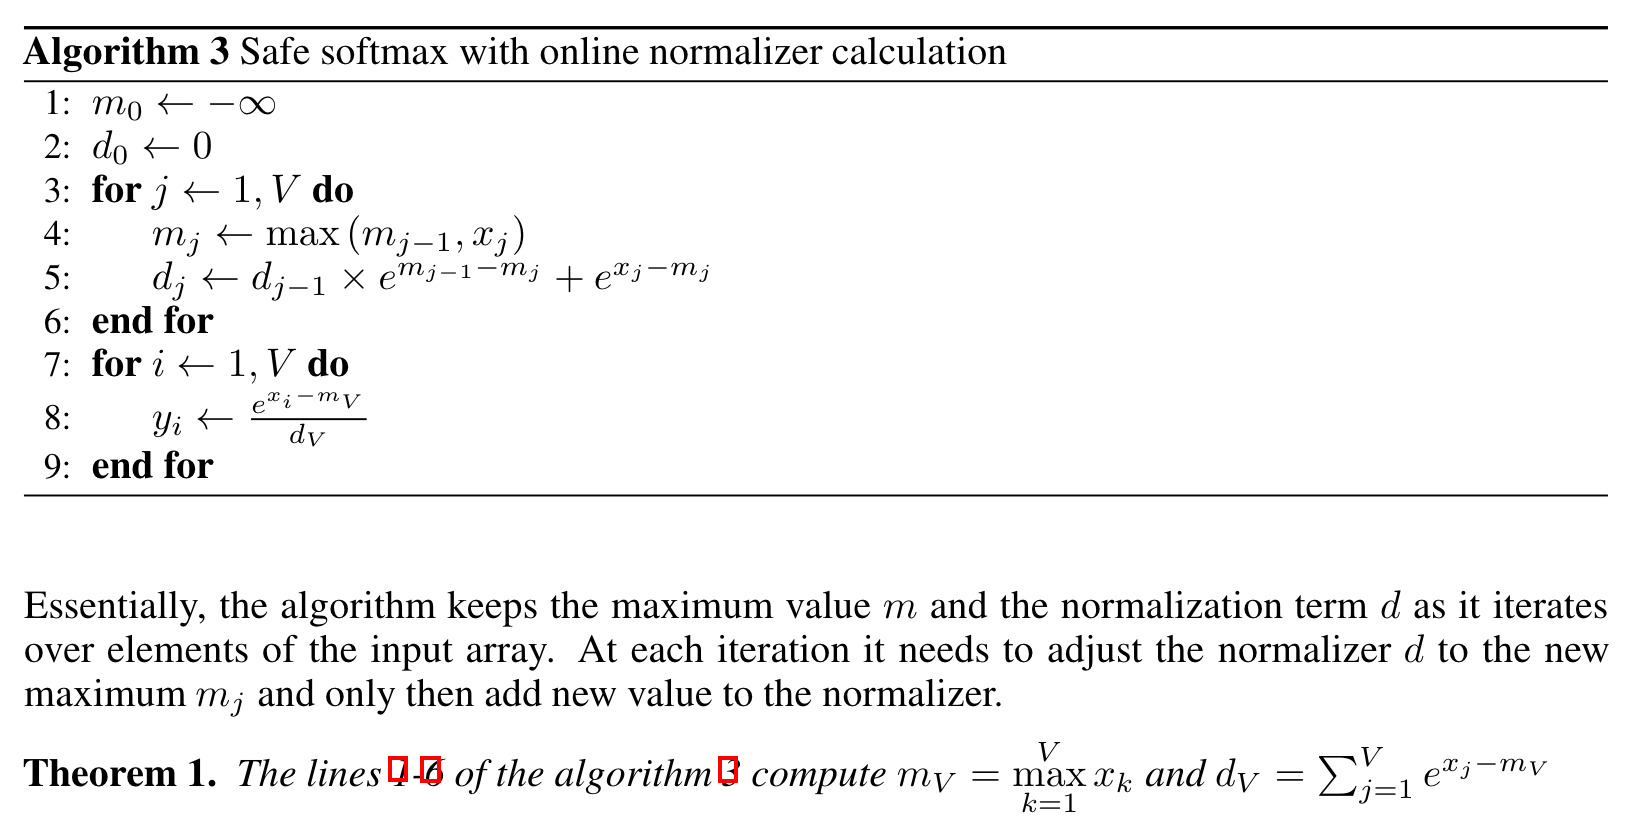

In [17]:
i_ = np.array([0.1,0.3,0.08,-0.09])
i_

array([ 0.1 ,  0.3 ,  0.08, -0.09])

In [18]:
d0 = 0
m = -np.inf
prev_m = m

for x in i_:
    m = max(m, x)
    d0 = d0 * np.exp(prev_m - m) + np.exp(x - m)
    prev_m = m

In [19]:
m, d0

(0.3, 3.298306425538625)

In [24]:
d0 == np.exp(i_- max(i_)).sum()

True

# Parallel online normalizer calculation
    - Divide list into multiple lists and calculate softmax on each

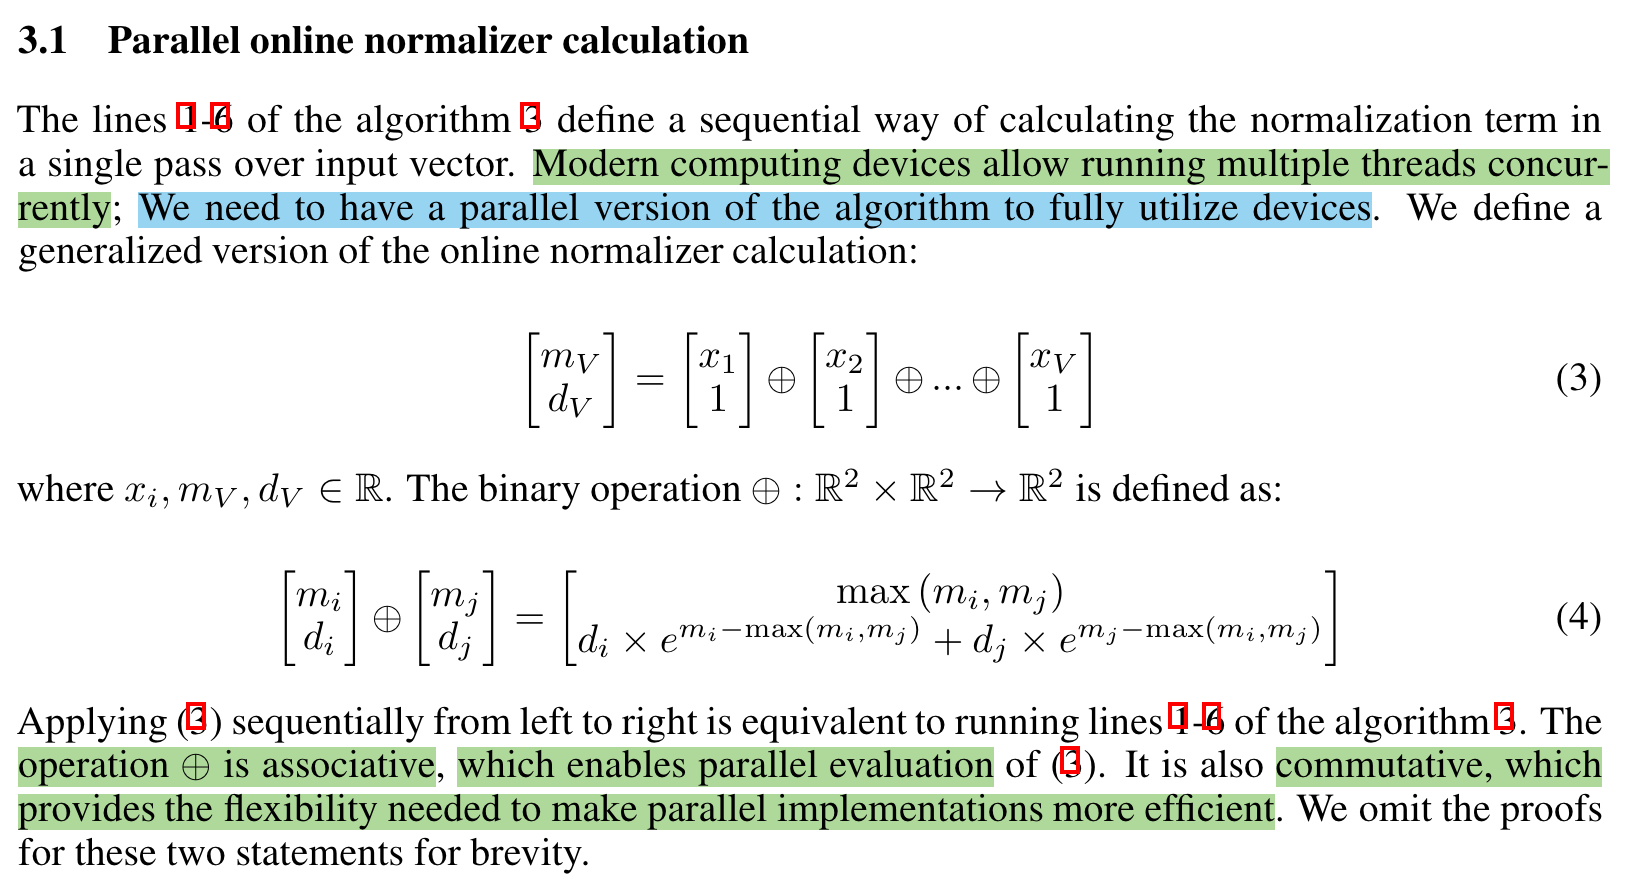

In [48]:
input_list = np.random.rand(10)
input_list

array([0.48403498, 0.0973621 , 0.51869646, 0.18187859, 0.7138846 ,
       0.15514045, 0.44284629, 0.46132317, 0.04277389, 0.776115  ])

In [49]:
list0 = input_list[:5]
list1 = input_list[5:]
print(list0)
print(list1)

[0.48403498 0.0973621  0.51869646 0.18187859 0.7138846 ]
[0.15514045 0.44284629 0.46132317 0.04277389 0.776115  ]


In [50]:
# calculations for list0
print(list0)
d0 = 0
m0 = -np.inf
prev_m = m0

for x in list0:
    m0 = max(m0, x)
    d0 = d0 * np.exp(prev_m - m0) + np.exp(x - m0)
    prev_m = m0
    
out0 = [np.exp(i-m0)/d0 for i in list0]

[0.48403498 0.0973621  0.51869646 0.18187859 0.7138846 ]


In [51]:
m0, d0

(0.7138846035667057, 3.744576752902566)

In [56]:
print(out0)
print(sum(out0))

[0.2122143952466955, 0.1441600564801097, 0.2196990253166501, 0.15687364462393708, 0.26705287833260766]
1.0


In [53]:
# calculations for list1
print(list1)
d1 = 0
m1 = -np.inf
prev_m = m1

for x in list1:
    m1 = max(m1, x)
    d1 = d1 * np.exp(prev_m - m1) + np.exp(x - m1)
    prev_m = m1
    
out1 = [np.exp(i-m1)/d1 for i in list1]

[0.15514045 0.44284629 0.46132317 0.04277389 0.776115  ]


In [54]:
m1, d1

(0.7761150042406394, 3.464240429166607)

In [57]:
print(out1)
print(sum(out1))

[0.15513370087560957, 0.20684985114591883, 0.21070731757079617, 0.13864556318507062, 0.2886635672226048]
1.0


### merge the 2 lists:

In [58]:
new_max = max(m0,m1)
new_max

0.7761150042406394

In [59]:
d_new = d0 * np.exp(m0-new_max) + d1 * np.exp(m1-new_max)
d_new

6.982893244115486

In [60]:
o0_new = [i * np.exp(m0-new_max) * d0/d_new for i in out0]
o0_new

[0.10693401046002154,
 0.07264169317845272,
 0.11070548651497772,
 0.07904802092062133,
 0.13456690933619692]

In [61]:
o1_new = [i * np.exp(m1-new_max) * d1/d_new for i in out1]
o1_new

[0.07696243085950258,
 0.10261901364604845,
 0.10453271770481722,
 0.06878260178401656,
 0.143207115595345]

In [63]:
print(sum(o0_new))
print(sum(o1_new))
print(sum(o0_new) + sum(o1_new))

0.5038961204102703
0.4961038795897298
1.0
